In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler

In [107]:
with open('/content/drive/MyDrive/echocardiogram/echocardiogram.data', 'r') as file:
    lines = file.readlines()

# Process each line manually to handle variable columns
data = [line.strip().split(',') for line in lines]

# Known column names
columns = ['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening',
           'epss', 'lvdd', 'wall-motion-score', 'wall-motion-index', 'mult', 'name', 'group', 'alive-at-1', 'unknown']

# Create DataFrame
df = pd.DataFrame(data, columns=columns)
df.drop(columns=['unknown'], inplace=True)

# Check data types before conversion
print(df.dtypes)

survival                 object
still-alive              object
age-at-heart-attack      object
pericardial-effusion     object
fractional-shortening    object
epss                     object
lvdd                     object
wall-motion-score        object
wall-motion-index        object
mult                     object
name                     object
group                    object
alive-at-1               object
dtype: object


In [108]:
# Specify the desired data types
# Use a dictionary to map column names to types
dtypes = {
    'survival': 'float',
    'still-alive': 'int',
    'age-at-heart-attack': 'float',
    'pericardial-effusion': 'int',
    'fractional-shortening': 'float',
    'epss': 'float',
    'lvdd': 'float',
    'wall-motion-score': 'float',
    'wall-motion-index': 'float',
    'mult': 'float',
    'name': 'string',
    'group': 'string',
    'alive-at-1': 'int'
}

# Convert the DataFrame and handle errors
for column, dtype in dtypes.items():
    if column in df.columns:
        # Convert and drop rows with errors
        df[column] = pd.to_numeric(df[column], errors='coerce') if dtype in ['int', 'float'] else df[column].astype(dtype)

In [109]:
# As we can observe, we get a lot of NaNs in the alive-at-1, so we can process the information to avoid it
df

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11.0,0.0,71.0,0,0.260,9.000,4.600,14.0,1.000,1.000,name,1,0.0
1,19.0,0.0,72.0,0,0.380,6.000,4.100,14.0,1.700,0.588,name,1,0.0
2,16.0,0.0,55.0,0,0.260,4.000,3.420,14.0,1.000,1.000,name,1,0.0
3,57.0,0.0,60.0,0,0.253,12.062,4.603,16.0,1.450,0.788,name,1,0.0
4,19.0,1.0,57.0,0,0.160,22.000,5.750,18.0,2.250,0.571,name,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,7.5,1.0,64.0,0,0.240,12.900,4.720,12.0,1.000,0.857,name,?,NaN
128,41.0,0.0,64.0,0,0.280,5.400,5.470,11.0,1.100,0.714,name,?,NaN
129,36.0,0.0,69.0,0,0.200,7.000,5.050,14.5,1.210,0.857,name,?,NaN
130,22.0,0.0,57.0,0,0.140,16.100,4.360,15.0,1.360,0.786,name,?,NaN


In [110]:
# If a patient is not still alive and survival < 12, then we know that alive-at-1 is False
df.loc[(df['survival'] < 12) & (df['still-alive'] == 0), 'alive-at-1'] = 0

# If a patient is still alive and survival > 12, then we know that alive-at-1 is True
df.loc[(df['survival'] >= 12) & (df['still-alive'] == 1), 'alive-at-1'] = 1

# We actually should not remove NaN values as this removes many cases where:
# either survival > 12, still-alive = 0 and alive-at-1 is NaN
# or survival < 12, still-alive = 1 and alive-at-1 is NaN

# This cases can be used for testing (not for validating as we don't know the ground truth)

In [111]:
# Potentially remove patients without data or those that cannot be used for the prediction
#  (i.e. survived less than one year but still alive)

filtered_df = df[~((df['survival'] < 12) & (df['still-alive'] == 1))].copy()

len(df), len(filtered_df)

(132, 98)

In [112]:
# Drop rows with NaN values (indicating conversion errors)
df.dropna(subset=['survival'], inplace=True)
filtered_df.dropna(subset=['survival'], inplace=True)

len(df), len(filtered_df)

(130, 96)

In [113]:
df.describe()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,alive-at-1
count,130.000000,130.000000,125.000000,130.000000,123.000000,116.000000,120.000000,127.000000,129.000000,127.000000,78.000000
mean,22.182923,0.323077,62.828232,0.184615,0.216870,12.188603,4.769350,14.428425,1.377674,0.776646,0.397436
std,15.858267,0.469461,8.374083,0.389486,0.107942,7.397604,0.810528,5.037237,0.453596,0.199865,0.492535
min,0.030000,0.000000,35.000000,0.000000,0.010000,0.000000,2.320000,2.000000,1.000000,0.140000,0.000000
25%,7.875000,0.000000,57.000000,0.000000,0.150000,7.000000,4.260000,11.000000,1.000000,0.712000,0.000000
50%,23.500000,0.000000,62.000000,0.000000,0.210000,11.000000,4.665000,14.000000,1.210000,0.786000,0.000000
75%,33.000000,1.000000,68.000000,0.000000,0.270000,16.100000,5.302500,16.500000,1.510000,0.857000,1.000000
max,57.000000,1.000000,86.000000,1.000000,0.610000,40.000000,6.780000,39.000000,3.000000,2.000000,1.000000


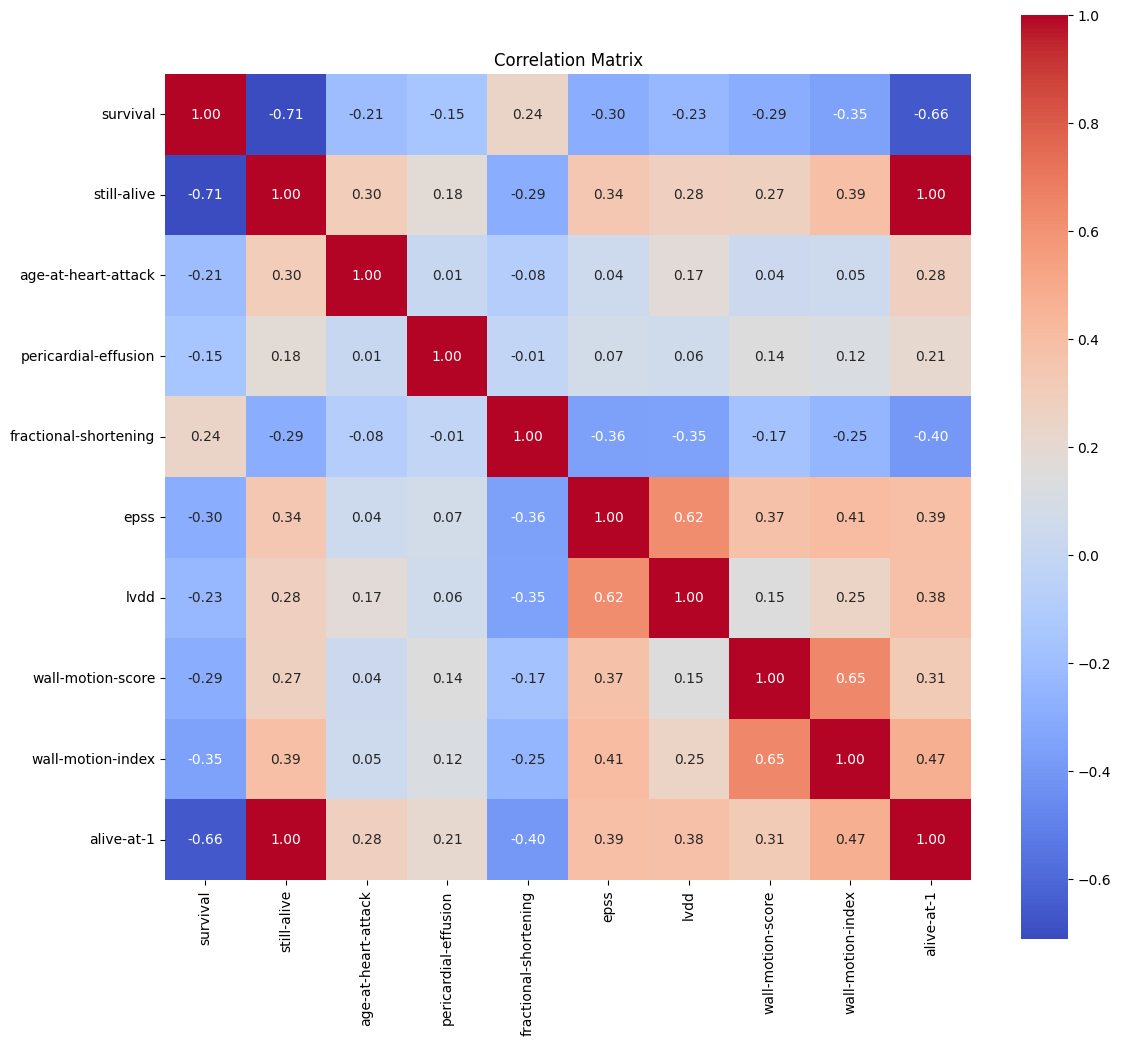

In [114]:
df_clean = df.drop(columns=['name', 'group', 'mult'])
plt.figure(figsize=(13, 12))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
# plt.show()
plt.savefig('corr_matrix.png')

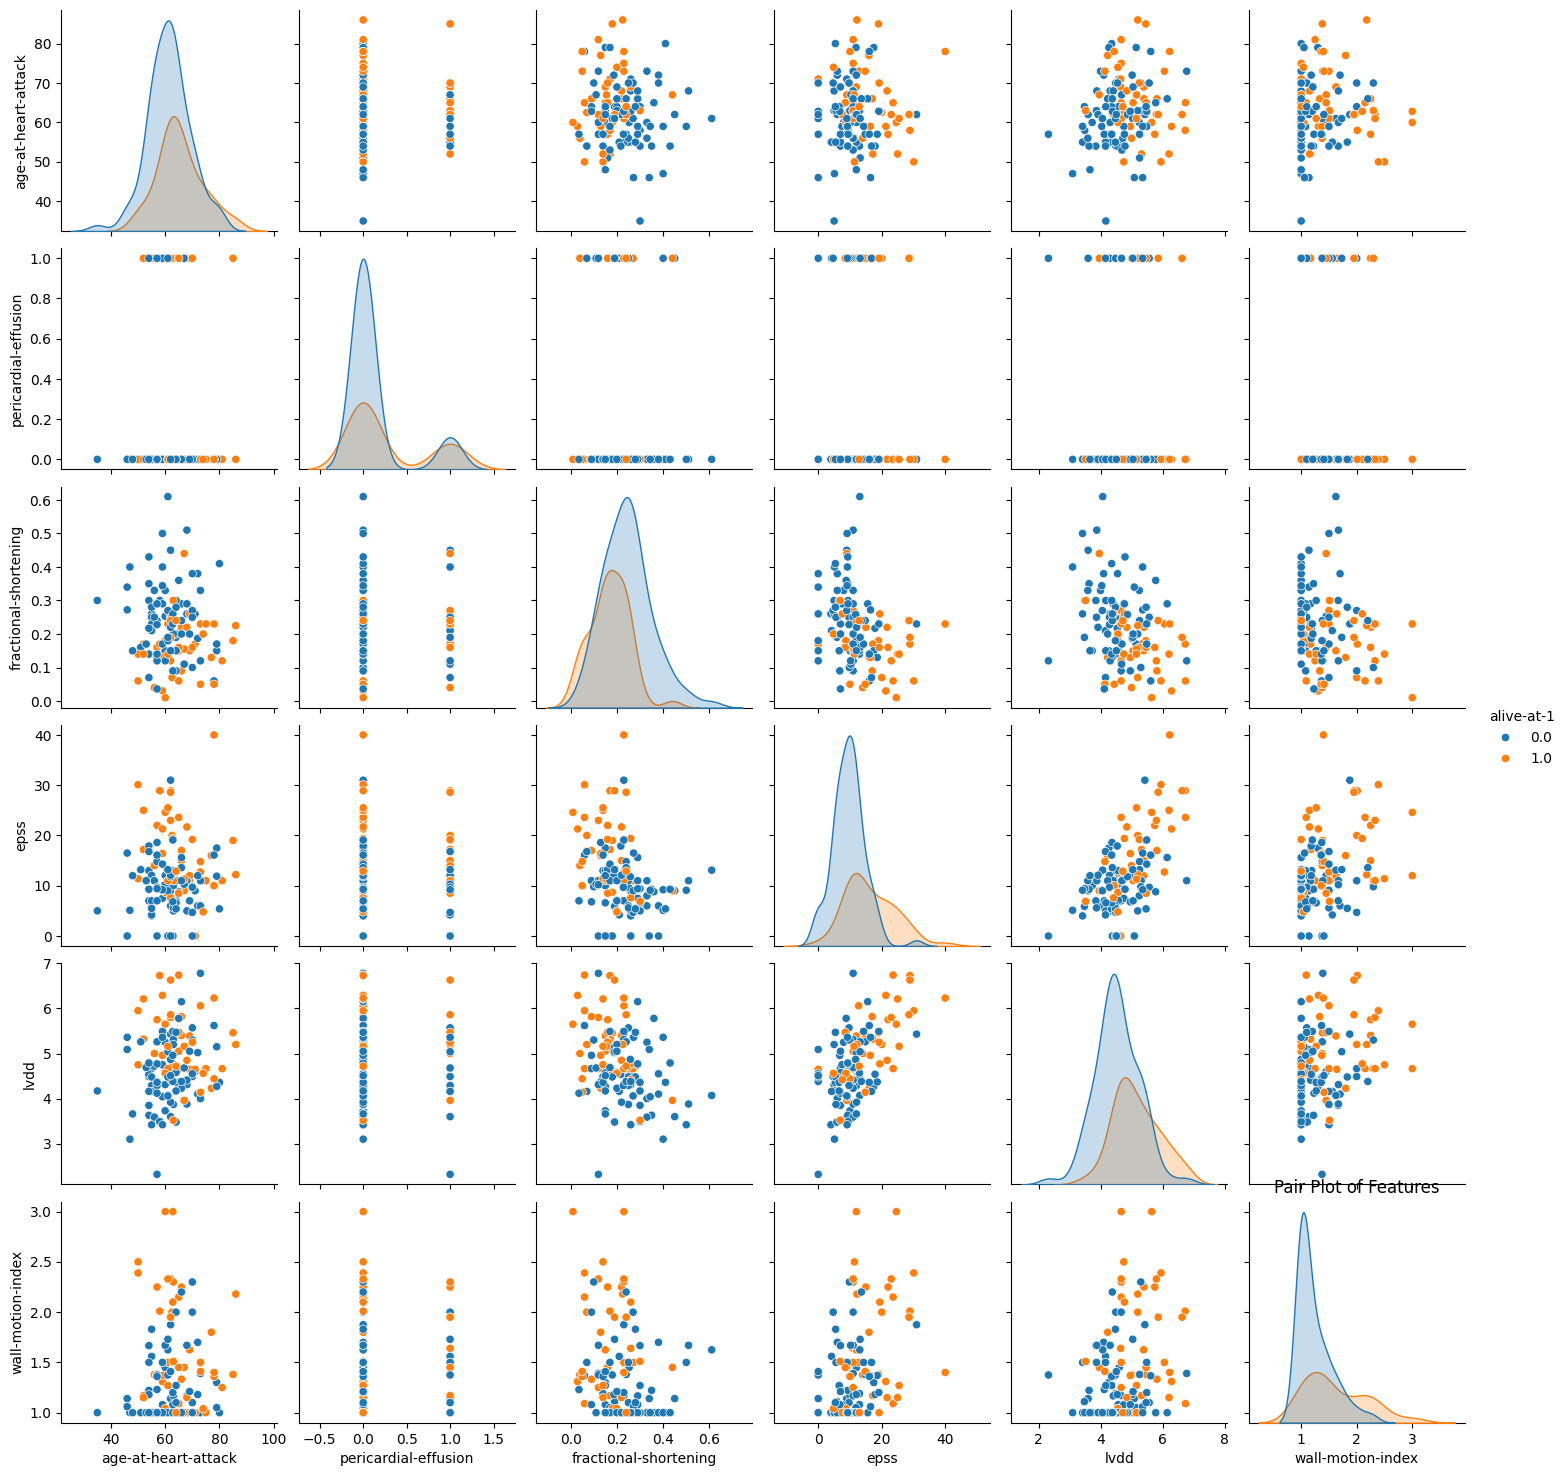

In [135]:
sns.pairplot(df_clean, hue='alive-at-1', diag_kind='kde')
plt.title("Pair Plot of Features")
plt.savefig('dist_matrix.png')
plt.show()

In [116]:
candidate_train_test = filtered_df.dropna(subset=['alive-at-1'], inplace=False).copy()

# Fill missing values with the appropriate measure (median) for each column
candidate_train_test['fractional-shortening'] = candidate_train_test['fractional-shortening'].fillna(candidate_train_test['fractional-shortening'].median())
candidate_train_test['epss'] = candidate_train_test['epss'].fillna(candidate_train_test['epss'].median())
candidate_train_test['lvdd'] = candidate_train_test['lvdd'].fillna(candidate_train_test['lvdd'].median())

### Random Forest

In [117]:
from sklearn.ensemble import RandomForestClassifier

df_clf = candidate_train_test

# Drop unnecessary columns
df_clean = df_clf.drop(columns=['name', 'group', 'mult', 'still-alive', 'wall-motion-score'])

# Split into features (X) and target (y)
X = df_clean.drop(columns=['alive-at-1'])
y = df_clean['alive-at-1']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.91
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       0.00      0.00      0.00         1

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


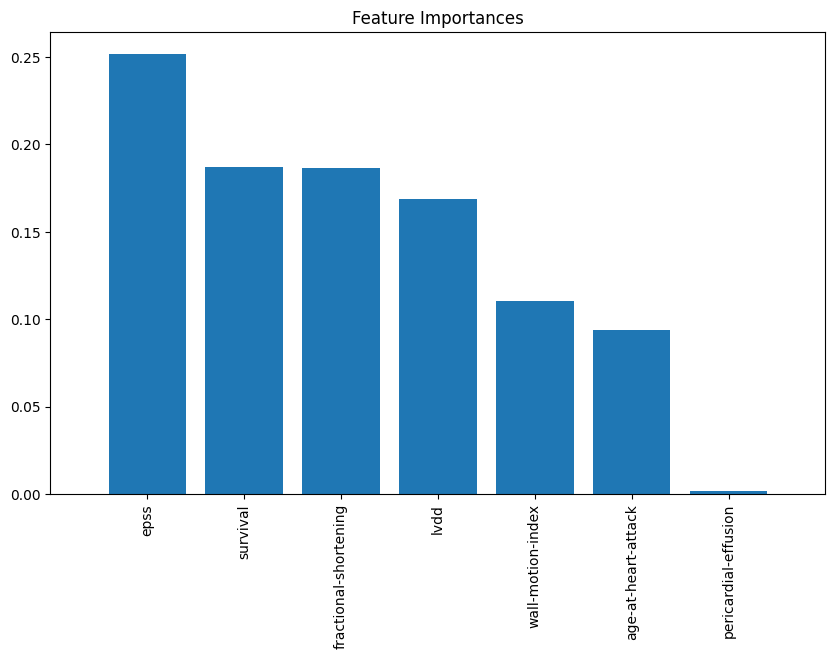

In [118]:
# Show what is driving the prediction
feature_importances = rf_clf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.show()

In [119]:
from xgboost import XGBClassifier

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.91
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       0.00      0.00      0.00         1

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


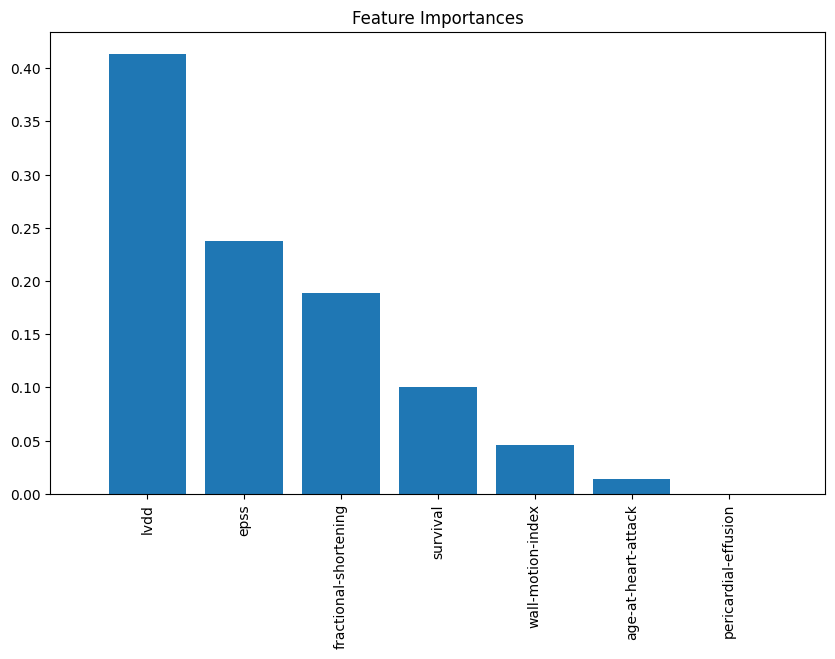

In [120]:
# Show what is driving the prediction
feature_importances = xgb_clf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.show()

In [121]:
# Use a heuristic to fill missing or invalid values
# Example: if 'survival' < 12, set 'alive-at-1' to 0; otherwise, set it to 1
df_clean2 = df_clean

df_clean2.loc[(df_clean2['alive-at-1'].isna()) & (df_clean2['survival'] < 12), 'alive-at-1'] = 1
df_clean2.loc[(df_clean2['alive-at-1'].isna()) & (df_clean2['survival'] >= 12), 'alive-at-1'] = 0

df_clf = df_clean2

# Split into features (X) and target (y)
X = df_clf.drop(columns=['alive-at-1'])
y = df_clf['alive-at-1']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.2f}")

XGBoost Accuracy: 0.91


## Infer alive-at-1 missing values

In [122]:
# Create a new column for rows with valid alive-at-1 values (0 or 1)
df['valid-alive-at-1'] = df['alive-at-1'].apply(lambda x: 1 if x in [0, 1] else 0)
df_clean = df.drop(columns=['name', 'group', 'mult', 'still-alive', 'wall-motion-score'])

# Separate rows with valid and invalid 'alive-at-1' labels
valid_rows = df_clean[df_clean['valid-alive-at-1'] == 1]
invalid_rows = df_clean[df_clean['valid-alive-at-1'] == 0]

# Drop the 'alive-at-1' column from the invalid rows (we'll predict this)
X_valid = valid_rows.drop(columns=['alive-at-1', 'valid-alive-at-1'])
y_valid = valid_rows['alive-at-1']

# Split the valid rows into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.2, random_state=42)

# Train a classifier (RandomForest in this case)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Use the trained classifier to predict the missing 'alive-at-1' values
X_invalid = invalid_rows.drop(columns=['alive-at-1', 'valid-alive-at-1'])
predicted_alive_at_1 = clf.predict(X_invalid)

# Assign the predicted values back to the original dataset
df.loc[df['valid-alive-at-1'] == 0, 'alive-at-1'] = predicted_alive_at_1

# Drop the 'valid-alive-at-1' column, it's no longer needed
df.drop(columns=['valid-alive-at-1'], inplace=True)

# Now you have a complete dataset with filled 'alive-at-1' labels
print(df['alive-at-1'].value_counts())

alive-at-1
0.0    83
1.0    47
Name: count, dtype: int64


### Logistic Regression

In [124]:
from sklearn.linear_model import LogisticRegression

df_clean = df.drop(columns=['name', 'group', 'mult', 'still-alive', 'survival','wall-motion-score'])
# Fill missing values with the appropriate measure (depends on distribution) for each column
df_clean['age-at-heart-attack'] = df_clean['age-at-heart-attack'].fillna(df_clean['age-at-heart-attack'].mean())
df_clean['fractional-shortening'] = df_clean['fractional-shortening'].fillna(candidate_train_test['fractional-shortening'].median())
df_clean['epss'] = df_clean['epss'].fillna(df_clean['epss'].median())
df_clean['lvdd'] = df_clean['lvdd'].fillna(df_clean['lvdd'].median())
# df_clean['wall-motion-score'] = df_clean['wall-motion-score'].fillna(df_clean['wall-motion-score'].mean())
df_clean['wall-motion-index'] = df_clean['wall-motion-index'].fillna(df_clean['wall-motion-index'].mean())

X = df_clean.drop(columns=['alive-at-1'])
y = df_clean['alive-at-1']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression
log_reg = LogisticRegression(max_iter=200, random_state=42)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.96
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        18
         1.0       1.00      0.88      0.93         8

    accuracy                           0.96        26
   macro avg       0.97      0.94      0.95        26
weighted avg       0.96      0.96      0.96        26



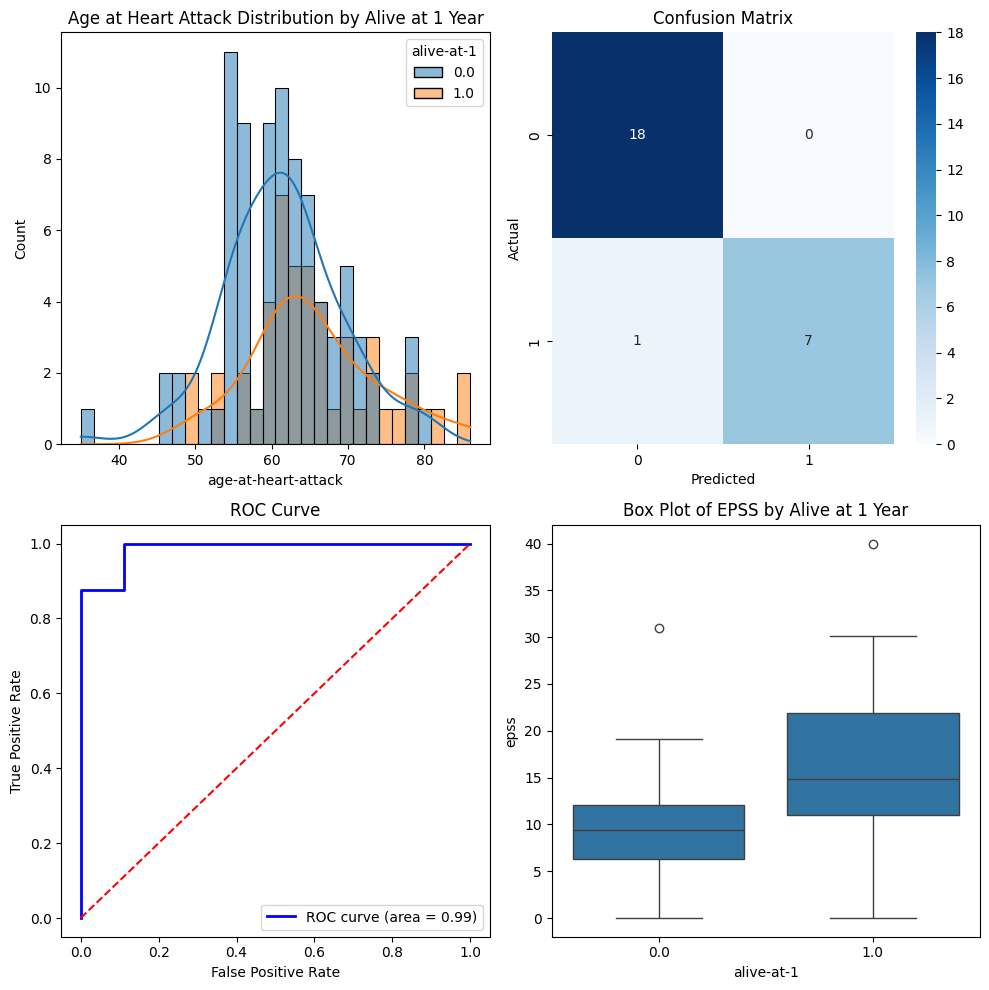

In [125]:
# Create a figure and a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

# Plot 1: Feature Distribution (Histogram)
sns.histplot(data=df_clean, x='age-at-heart-attack', hue='alive-at-1', bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age at Heart Attack Distribution by Alive at 1 Year')

# Plot 2: Box Plot
sns.boxplot(x='alive-at-1', y='epss', data=df_clean, ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of EPSS by Alive at 1 Year')

# Plot 3: ROC Curve
y_probs = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
axes[1, 0].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axes[1, 0].set_title('ROC Curve')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend(loc='lower right')

# Plot 4: Confusion Matrix
cm = confusion_matrix(y_test, log_reg.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Adjust the layout so the titles and labels don’t overlap
plt.tight_layout()

# Save image
plt.savefig("4_plots_grid.png", dpi=300, bbox_inches='tight')

# Display the plots
plt.show()

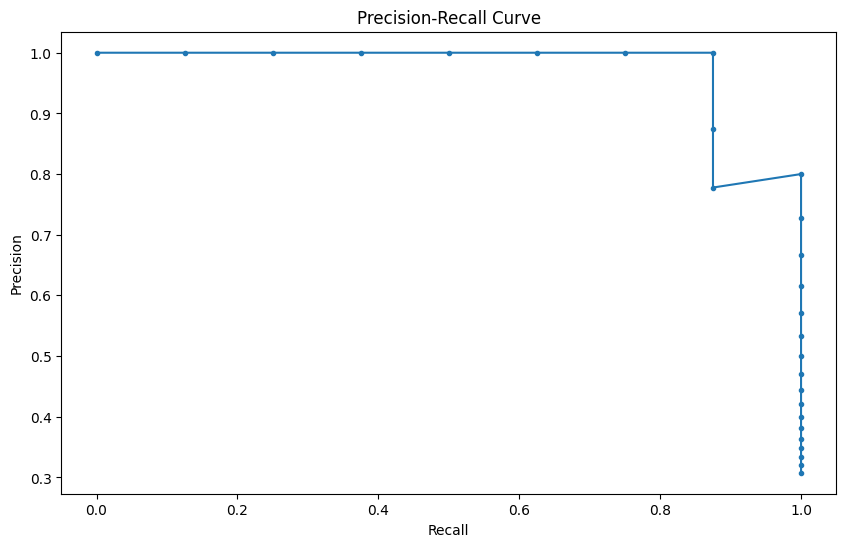

In [126]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### XGBoost

In [127]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.73
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82        18
         1.0       0.60      0.38      0.46         8

    accuracy                           0.73        26
   macro avg       0.68      0.63      0.64        26
weighted avg       0.71      0.73      0.71        26



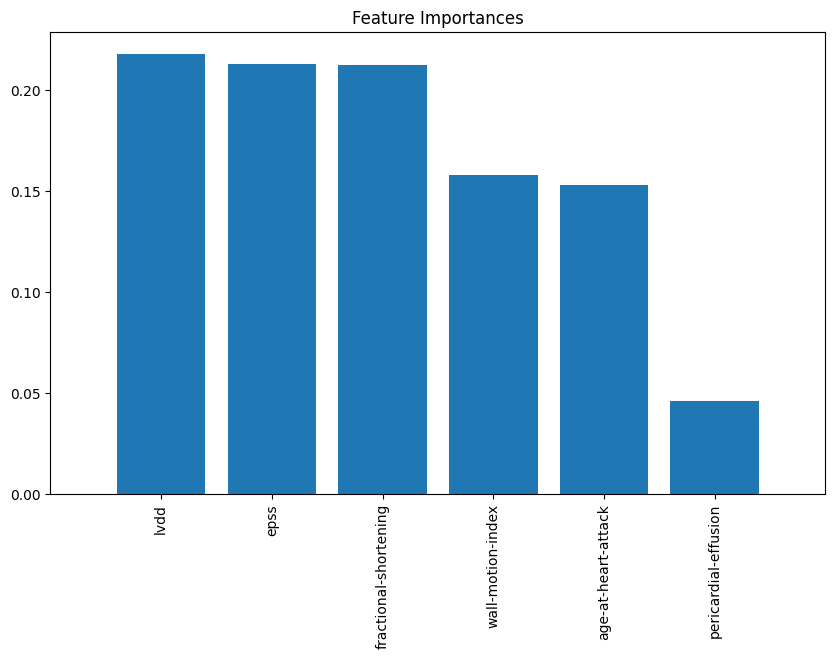

In [128]:
# Show what is driving the prediction
feature_importances = xgb_clf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.show()

### Support Vector Machine

In [129]:
from sklearn.svm import SVC

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train SVM
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

SVM Accuracy: 0.73
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84        18
         1.0       1.00      0.12      0.22         8

    accuracy                           0.73        26
   macro avg       0.86      0.56      0.53        26
weighted avg       0.81      0.73      0.65        26



### K-Nearest Neighbors (KNN)

In [130]:
from sklearn.neighbors import KNeighborsClassifier

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

KNN Accuracy: 0.81
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86        18
         1.0       0.71      0.62      0.67         8

    accuracy                           0.81        26
   macro avg       0.78      0.76      0.77        26
weighted avg       0.80      0.81      0.80        26



### Decision Tree

In [131]:
from sklearn.tree import DecisionTreeClassifier

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train decision tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.58
              precision    recall  f1-score   support

         0.0       0.73      0.61      0.67        18
         1.0       0.36      0.50      0.42         8

    accuracy                           0.58        26
   macro avg       0.55      0.56      0.54        26
weighted avg       0.62      0.58      0.59        26



### Naive Bayes

In [132]:
from sklearn.naive_bayes import GaussianNB

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = nb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Naive Bayes Accuracy: 0.88
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        18
         1.0       0.73      1.00      0.84         8

    accuracy                           0.88        26
   macro avg       0.86      0.92      0.88        26
weighted avg       0.92      0.88      0.89        26



In [133]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [134]:
scores = cross_val_score(log_reg, X, y, cv=5)
print(f"Cross-Validation Accuracy: {scores.mean():.2f}")

Cross-Validation Accuracy: 0.75
